In [1]:
%matplotlib inline

In [2]:
import inspect
import itertools
import json
import os
import time
from typing import Callable

import kwant
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.signal as signal
import scipy.sparse.linalg as sla
import xarray as xr
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster
from tqdm.notebook import tqdm

In [3]:
from fhj import fhj_hamiltonian_sym, generate_pf_tripartite, make_2D_system
from physics_utils import constants

constants.m_star = 0.026
constants.c_k = (
    constants.hbar**2
    / (2 * constants.m_star * constants.m_e)
    / (constants.eV * 1e-3 * 1e-18)
)

In [4]:
simname = "ruben_test_2"

In [5]:
def get_default_params() -> dict:
    """
    Generate the default prameters dict.
    """

    ############### POTENTIAL LANDSCAPE #######################

    params = {
        # Material parameters
        "k_c": 38.0998212 / 0.026,
        # Dresselhaus spin-orbit coupling
        "beta": 0,
        ##########
        "alpha_c": 0,
        # Electrostatic potential landscape
        "V": lambda *args: 0,
        # Superconductive pairing potential
        "Delta": lambda *args: 0,
        "theta": lambda *args: 0,
        # SOC field
        "alpha_x": lambda *args: 0,
        "alpha_y": lambda *args: 0,
        "alpha_z": lambda *args: 0,
        # Zeeman field
        "h_x": lambda *args: 0,
        "h_y": lambda *args: 0,
        "h_z": lambda *args: 0,
        # Functions
        "cos": np.cos,
        "sin": np.sin,
    }
    return params

In [6]:
def get_default_pf_params_tripartite() -> dict:

    """
    Default potential parameters.
    """

    D0 = 0.250  # Gap in meV

    pf_params = dict(
        L_junction=180,
        mu_C=6,
        mu_L=4,
        mu_R=4,
        L_barr_L=15,
        L_barr_R=15,
        V_barr_L=3,
        V_barr_R=3,
        Delta_0=1 * D0,
        theta_LR=np.pi,
        alpha_z_L= 2.0,
        alpha_z_C= 2.0,
        alpha_z_R= 2.0,
        h_x_L=0.0 * D0,
        h_x_C=0.0 * D0,
        h_x_R=0.0 * D0,
        h_y_L=0.0 * D0,
        h_y_C=0.0 * D0,
        h_y_R=0.0 * D0,
    )

    return pf_params

## Testing 

In [7]:
pf_params = get_default_pf_params_tripartite()
V, Delta, theta, alpha_x, alpha_y, alpha_z, h_x, h_y, h_z = generate_pf_tripartite(
    **pf_params
)

In [8]:
L_x = 3000  # Length in nanometers
a_x = 2  # Discretization step

L_y = 160  # Width in nanometers
a_y = 2000  # Discretization step. Setting a_y to be much bigger to L_y creates a 1D system

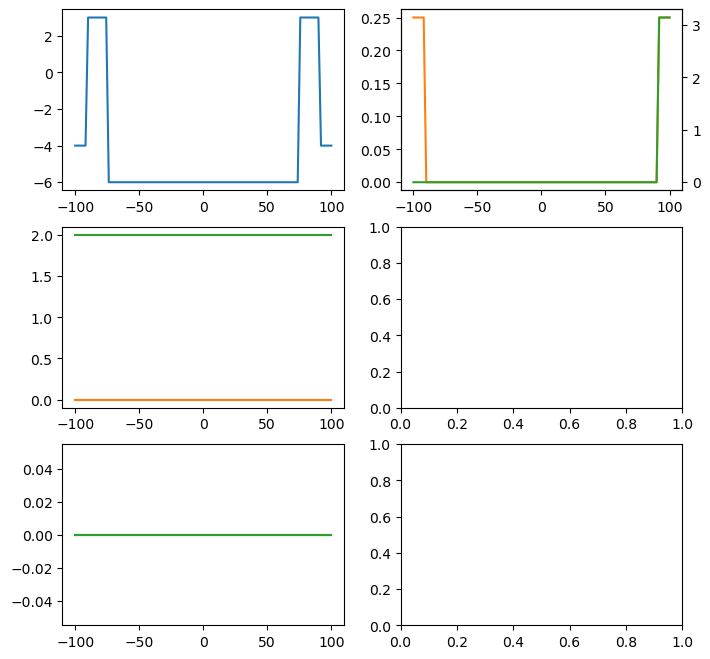

In [9]:
x = np.linspace(-100, 100, 100)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

ax[0, 0].plot(x, V(x, 0))
ax[0, 1].plot(x, Delta(x, 0), "C1")
ax[0, 1].twinx().plot(x, theta(x, 0), "C2")

ax[1, 0].plot(x, alpha_x(x, 0), "C0")
ax[1, 0].plot(x, alpha_y(x, 0), "C1")
ax[1, 0].plot(x, alpha_z(x, 0), "C2")

ax[2, 0].plot(x, h_x(x, 0), "C0")
ax[2, 0].plot(x, h_y(x, 0), "C1")
ax[2, 0].plot(x, h_z(x, 0), "C2")

In [10]:
# syst, lat, hop = make_2D_system(L_x=L_x, L_y=L_y, a_x=a_x, a_y=a_y, with_leads=False)

# fig, ax = plt.subplots(figsize=(20, 2))
# kwant.plot(syst, ax=ax)

# ax.set_xlim(-200, 200)

In [11]:
theta_N = 96
theta_ax = np.linspace(0, 2 * np.pi, theta_N, endpoint=False)
dtheta = theta_ax[1]

k = 80

In [12]:
syst, lat = make_2D_system(L_x=L_x, L_y=L_y, a_x=a_x, a_y=a_y)

In [13]:
def diag_theta(params, theta_ax, k):

    theta_N = len(theta_ax)

    ws = []
    vs = []

    for n in range(theta_N):

        theta_v = theta_ax[n]
        params["theta"] = lambda x, y: theta_v * np.heaviside(x, 0)

        ham = syst.hamiltonian_submatrix(params=params, sparse=True)
        w, v = sla.eigsh(ham, sigma=0, which="LM", k=k)

        idxs = np.argsort(w)
        ws.append(w[idxs])
        vs.append(v[:, idxs])

    ws = np.array(ws)
    vs = np.array(vs)

    vs = None

    return ws, vs

In [14]:
# %%time
# params = get_default_params()
# pf_params = get_default_pf_params_tripartite()
# V, Delta, theta, alpha_x, alpha_y, alpha_z, h_x, h_y, h_z = generate_pf_tripartite(
#     **pf_params
# )
# params.update(
#     V=V,
#     Delta=Delta,
#     theta=theta,
#     alpha_x=alpha_x,
#     alpha_y=alpha_y,
#     alpha_z=alpha_z,
#     h_x=h_x,
#     h_y=h_y,
#     h_z=h_z,
# )

# ws, vs = diag_theta(params, theta_ax, k=k)

# fig, ax = plt.subplots()
# ax.plot(theta_ax, ws, "-")

# ax.set_ylim(-1, 1)

# Phase diagram

In [15]:
# a_N = 101
# a_ax = np.linspace(0, 2 * np.pi, a_N)

# np.arange(50, 550, 4)
# a_N = len(a_ax)

b_N = 41
b_ax = np.linspace(0, 5, b_N) * 0.250

# b_N = 81
# b_ax = np.linspace(0, 10, b_N)

a_N = 32
a_ax = np.linspace(0, 2 * np.pi, a_N, endpoint=False)

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")


def wrapper(prm_tpl, k=k):

    a, b = prm_tpl

    # # Change potentials parameters
    pf_params = get_default_pf_params_tripartite()
    pf_params.update(
        # L_junction=a,
        # mu_C=b,
        # mu_L=a,
        # mu_R=a,
        # L_barr_L=20,
        # L_barr_R=20,
        # V_barr_L= a,
        # V_barr_R= a,
        # Delta_0=D0,
        # theta_LR=np.pi,
        # alpha_x_L=b,
        # alpha_y_L=b,
        # alpha_z_L=b,
        # alpha_x_C=b,
        alpha_y_C= 2.0 * np.sin(a),
        alpha_z_C= 2.0 * np.cos(a),
        # alpha_x_R=b,
        # alpha_y_R=b,
        # alpha_z_R=b,
        # h_x_L=a,# * np.cos(b),  # b / np.sqrt(2),  # np.sqrt(a**2+b**2),
        # h_y_L=a * np.sin(b),
        h_x_C= b * 0.250 * np.cos(np.pi/6) * np.cos(np.pi/6),  # * np.cos(b),
        h_y_C= b * 0.250 * np.sin(np.pi/6) * np.cos(np.pi/6),
        h_z_C= b * 0.250 * np.sin(np.pi/6),
        # h_x_R=a,# * np.cos(b),
        # h_y_R=a * np.sin(b),
    )
    # Generate potentials
    V, Delta, theta, alpha_x, alpha_y, alpha_z, h_x, h_y, h_z = generate_pf_tripartite(
        **pf_params
    )

    # Change other parameters
    params = get_default_params()
    params.update(
        V=V,
        Delta=Delta,
        theta=theta,
        alpha_x=alpha_x,
        alpha_y=alpha_y,
        alpha_z=alpha_z,
        h_x=h_x,
        h_y=h_y,
        h_z=h_z,
    )

    return diag_theta(params, theta_ax, k)

In [16]:
print("Creating tuple list")

idx_tpl_list = []

for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):
    idx_tpl_list.append((i, j))

prm_tpl_list = list(map(lambda tpl: (a[tpl], b[tpl]), idx_tpl_list))

print(f"{len(prm_tpl_list)} tuples")

Creating tuple list


  0%|          | 0/1312 [00:00<?, ?it/s]

1312 tuples


In [17]:
env_extra = [
    "export OMP_NUM_THREADS=4",
    "export OPENBLAS_NUM_THREADS=4",
    "export MKL_NUM_THREADS=4",
    "export VECLIB_MAXIMUM_THREADS=4",
    "export NUMEXPR_NUM_THREADS=4",
]

cluster = PBSCluster(
    walltime="12:00:00",
    cores=10,
    memory="185gb",
    account="ku_00125",
    resource_spec="nodes=1:ppn=40:thinnode,mem=185gb",
    local_directory="./workspace/temp/local",
    log_directory="./workspace/temp/log",
    job_extra_directives=["-W group_list=ku_00125"],
    job_script_prologue=env_extra,
)

######################### LOCAL CLUSTER ###########################
# cluster = LocalCluster(n_workers=4)

In [18]:
client = Client(cluster)

In [19]:
print(cluster.job_script())
print(client)

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -A ku_00125
#PBS -l nodes=1:ppn=40:thinnode,mem=185gb
#PBS -l walltime=12:00:00
#PBS -e ./workspace/temp/log/
#PBS -o ./workspace/temp/log/
#PBS -W group_list=ku_00125
export OMP_NUM_THREADS=4
export OPENBLAS_NUM_THREADS=4
export MKL_NUM_THREADS=4
export VECLIB_MAXIMUM_THREADS=4
export NUMEXPR_NUM_THREADS=4
/home/people/andmai/workspace/miniconda3/envs/fnwjj/bin/python -m distributed.cli.dask_worker tcp://10.45.12.96:43178 --nthreads 2 --nworkers 5 --memory-limit 34.46GiB --name dummy-name --nanny --death-timeout 60 --local-directory ./workspace/temp/local

<Client: 'tcp://10.45.12.96:43178' processes=0 threads=0, memory=0 B>


In [20]:
cluster

In [21]:
# client.wait_for_workers(450)
client.upload_file("physics_utils.py")
client.upload_file("fhj.py");

In [22]:
print("Launching futures")
start_time = time.time()
futures = client.map(wrapper, prm_tpl_list)

Launching futures


In [23]:
cluster.scale(1000)

In [24]:
from IPython.display import clear_output

dt = 5
errdretry = True
pending_retry_time = 1e50

futures_number = len(futures)

log = ""

time_reset = time.time()

while True:
    clear_output(wait=True)

    n_f = int(np.sum([1 for f in futures if f.status == "finished"]))
    n_p = int(np.sum([1 for f in futures if f.status == "pending"]))
    n_l = int(np.sum([1 for f in futures if f.status == "lost"]))
    n_e = int(np.sum([1 for f in futures if f.status == "error"]))

    pc_f = n_f / futures_number
    pc_p = n_p / futures_number
    pc_l = n_l / futures_number
    pc_e = n_e / futures_number

    print(f"Finished : {n_f:9d} ( {pc_f:6.2%} )")
    print(f"Pending  : {n_p:9d} ( {pc_p:6.2%} )")
    print(f"Lost     : {n_l:9d} ( {pc_l:6.2%} )")
    print(f"Error    : {n_e:9d} ( {pc_e:6.2%} )")

    if start_time:
        time_passed = time.time() - start_time
        print(
            f"TSS      : {int(time_passed//3600)}H {int(time_passed%3600)//60}M {(time_passed%60):4.2f}S"
        )

    if pc_f != 0:
        eta = time_passed * (1 - pc_f) / pc_f
        print(f"ETA      : {int(eta//3600)}H {int(eta%3600)//60}M {(eta%60):4.2f}S")

    if (pc_p == 0) and (pc_l == 0):
        break

    print("\n\n\n" + log)

    if errdretry:

        futures_erred = [f for f in futures if f.status == "error"]

        for f in futures_erred:
            log += f"{int(time_passed//3600)}H {int(time_passed%3600)//60}M {(time_passed%60):4.2f}S : "
            log += str(type(f.exception())) + "\n"
            f.retry()

    if time.time() - time_reset > pending_retry_time:

        futures_pending = [f for f in futures if f.status == "pending"]
        for f in futures_pending:
            f.retry()

        log += f"{int(time_passed//3600)}H {int(time_passed%3600)//60}M {(time_passed%60):4.2f}S : "
        log += "Repeat pending futures.\n"

        time_reset = time.time()

    time.sleep(dt)

Finished :      1312 ( 100.00% )
Pending  :         0 (  0.00% )
Lost     :         0 (  0.00% )
Error    :         0 (  0.00% )
TSS      : 0H 31M 39.03S
ETA      : 0H 0M 0.00S


In [25]:
futures_pending = [
    f
    for f in futures
    if f.status == "pending" or f.status == "lost" or f.status == "error"
]
for f in tqdm(futures_pending):
    f.retry()

0it [00:00, ?it/s]

In [26]:
print("Collecting results")

futures_N = len(futures)
res = client.gather(futures)

In [27]:
ws = np.zeros((a_N, b_N, theta_N, k))

for m in tqdm(range(futures_N)):
    i, j = idx_tpl_list[m]
    ws[i, j], _ = res[m]

  0%|          | 0/1312 [00:00<?, ?it/s]

In [28]:
pd = xr.DataArray(
    ws,
    dims=("a", "b", "theta", "k"),
    coords={
        "a": a_ax,
        "b": b_ax,
        "theta": theta_ax,
    },
)

ds = pd.to_dataset(name="ws")

In [29]:
os.makedirs(f"./output/{simname}/", exist_ok=True)

In [30]:
ds.to_netcdf(
    f"./output/{simname}/{simname}.nc"
)  # , engine="h5netcdf", invalid_netcdf=True)

In [31]:
def clean_dp(dp: dict) -> dict:
    for key in dp.keys():
        if isinstance(dp[key], np.ufunc):
            dp[key] = None
        elif isinstance(dp[key], Callable):
            dp[key] = inspect.getsource(dp[key])
    return dp


dp_saved = get_default_params()
dp_saved = clean_dp(dp_saved)
with open(
    f"./output/{simname}/{simname}-params.json",
    "w",
) as json_file:
    json.dump(dp_saved, json_file, indent=4)


dp_saved = get_default_pf_params_tripartite()
dp_saved = clean_dp(dp_saved)
with open(
    f"./output/{simname}/{simname}-pf-params.json",
    "w",
) as json_file:
    json.dump(dp_saved, json_file, indent=4)

In [32]:
cluster.close()
client.close()

2023-05-23 16:16:25,478 - distributed.client - ERROR - 
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/people/andmai/workspace/miniconda3/envs/fnwjj/lib/python3.10/site-packages/distributed/comm/core.py", line 291, in connect
    comm = await asyncio.wait_for(
  File "/home/people/andmai/workspace/miniconda3/envs/fnwjj/lib/python3.10/asyncio/tasks.py", line 445, in wait_for
    return fut.result()
  File "/home/people/andmai/workspace/miniconda3/envs/fnwjj/lib/python3.10/site-packages/distributed/comm/tcp.py", line 503, in connect
    convert_stream_closed_error(self, e)
  File "/home/people/andmai/workspace/miniconda3/envs/fnwjj/lib/python3.10/site-packages/distributed/comm/tcp.py", line 142, in convert_stream_closed_error
    raise CommClosedError(f"in {obj}: {exc.__class__.__name__}: {exc}") from exc
distributed.comm.core.CommClosedError: in <distributed.co